In [1]:
!pip install ckip_transformers
!pip install wordcloud
!pip install pyLDAvis

     ---------------------------------------- 1.7/1.7 MB 366.6 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136904 sha256=be9b28e53e43be54a8879042cc7a10678b4319dbd2757a0067dda886341ff42a
  Stored in directory: c:\users\jerem\appdata\local\pip\cache\wheels\57\a4\86\d10c6c2e0bf149fbc0afb0aa5a6528ac35b30a133a0270c477
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=b0b0462c4a18b917d29a08d76cf4476aa959bf94f834fda87b228409d4ee06dc
  Stored in directory: c:\users\jerem\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built pyLDAvis sklearn


# 匯入基本套件

In [2]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib as plt

import warnings
warnings.filterwarnings("ignore")

# 匯入ckip的斷詞、詞性標示、命名實體標示套件

In [3]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
# Initialize drivers
print("Initializing drivers ... WS")
ws_driver = CkipWordSegmenter(model="bert-base", device=0)
print("Initializing drivers ... POS")
pos_driver = CkipPosTagger(model="bert-base", device=0)
print("Initializing drivers ... NER")
ner_driver = CkipNerChunker(model="bert-base", device=0)
print("Initializing drivers ... all done")
print()

Initializing drivers ... WS
Initializing drivers ... POS
Initializing drivers ... NER
Initializing drivers ... all done



# 讀取資料檔 資料集為ptt hatepolitics版上文章

In [4]:
ORIGINAL_DATA = pd.read_csv("./data.csv")
ORIGINAL_DATA = ORIGINAL_DATA.drop(columns = ["Unnamed: 0"])

TEST_DATA = ORIGINAL_DATA.sample(n = 500, random_state=42)
content = TEST_DATA["content"]


In [5]:
def read_stopword():
    with open("./stopwords_TW.txt", "r", encoding="utf-8") as f:
        stopword = [word.strip("\n") for word in f.readlines()]
    return stopword
stopwords = read_stopword()

def do_CKIP_WS(article):
    ws_results = ws_driver([str(article)])
    return ws_results

def do_CKIP_POS(ws_result):
    # write your code in here
    pos = pos_driver(ws_result[0])
    all_list = []
    for sent in pos:

        all_list.append(sent)
    return all_list

def pos_filter(pos):
    for i in list(set(pos)):
        if i.startswith("N") or i.startswith("V"):
            return "Yes"
        else:
            continue

def remove_number_url(ws):
    number_pattern = "^\d+\.?\d*"
    url_pattern = "^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    space_pattern = "^ .*"
    num_regex = re.match(number_pattern, ws)
    url_regex = re.match(url_pattern, ws)
    space_regex = re.match(space_pattern, ws)
    if num_regex ==  None and url_regex == None and space_regex == None:

        return True
    else:

        return False
    
def cleaner(ws_results, pos_results, stopwords):
    word_lst = []
    for ws, pos in zip(ws_results[0], pos_results):
        in_stopwords_or_not = ws not in stopwords
        if_len_greater_than_1 = len(ws) > 1
        is_V_or_N = pos_filter(pos)
        is_num_or_url = remove_number_url(ws)
        if in_stopwords_or_not and if_len_greater_than_1 and is_V_or_N == "Yes" and is_num_or_url:
            word_lst.append(str(ws))
        else:
            pass
    return word_lst


In [6]:
seg_lst = []
for i in range(len(TEST_DATA)):
    ws_results = do_CKIP_WS(content.iloc[i])
    pos_results = do_CKIP_POS(ws_results)
    word_lst = cleaner(ws_results, pos_results, stopwords)
    seg_lst.append(word_lst)


Inference: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


In [26]:
seg_lst[0]

['高潮',
 '歡呼',
 '民調',
 '民調',
 '東西',
 '參考',
 '選舉',
 '變數',
 '太多',
 '在乎',
 '投票',
 '仔細',
 '民調',
 '落後',
 '一點點',
 '一點',
 '棄保',
 '國民黨',
 '瞬間',
 '翻盤',
 '民調',
 '細節',
 '投票',
 '比例',
 '碾壓',
 '對手',
 '前景',
 '樂觀',
 '有利',
 '民調',
 '悲痛',
 '哭喊',
 '民調',
 '可悲',
 '可嘆',
 '可憐']

# 全部文章文字雲

(-0.5, 399.5, 199.5, -0.5)

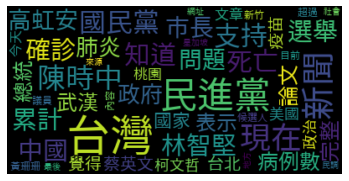

In [8]:
# -*- coding: utf-8 -*-
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager
from collections import Counter

word_count = Counter()
for i in seg_lst:
    word = Counter(i)
    word_count+=word
  


font_path = './TaipeiSansTCBeta-Regular.ttf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(word_count)
# wordcloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# gensim LDA

In [9]:
import gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from pprint import pprint


In [10]:
dictionary = corpora.Dictionary(seg_lst)
corpus = [dictionary.doc2bow(i) for i in seg_lst]

In [11]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# 查看第一篇文章中字詞的tf-idf分布值
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.09385866569469331),
 (1, 0.17067559227759785),
 (2, 0.1475513932014257),
 (3, 0.17067559227759785),
 (4, 0.12732999523276825),
 (5, 0.20732658067254142),
 (6, 0.17067559227759785),
 (7, 0.12442719412525362),
 (8, 0.20732658067254142),
 (9, 0.0624121611376366),
 (10, 0.1610781825201972),
 (11, 0.0917055852916809),
 (12, 0.1128072762150125),
 (13, 0.20732658067254142),
 (14, 0.20841159231319228),
 (15, 0.1424087465774098),
 (16, 0.09385866569469331),
 (17, 0.13795398344402512),
 (18, 0.15363385316580902),
 (19, 0.1842023815963693),
 (20, 0.13050965408963688),
 (21, 0.5502335117500854),
 (22, 0.17067559227759785),
 (23, 0.17067559227759785),
 (24, 0.15363385316580902),
 (25, 0.1842023815963693),
 (26, 0.13795398344402512),
 (27, 0.17067559227759785),
 (28, 0.06031328248063581),
 (29, 0.1842023815963693)]


In [12]:
# 查看文章中詞頻分布情形
tfidf_lst = []
for num, (c,t) in enumerate(zip(corpus, corpus_tfidf)):
    for i in range(len(c)):
        tfidf_lst.append(
            {"article_id" : num,
             "word_id" : c[i][0],
             "word" : dictionary[c[i][0]],
             "times" : c[i][1],
             "tf-idf" : round(t[i][1],3)})
        
df_tfidf = pd.DataFrame(tfidf_lst)

In [13]:
df_tfidf

,article_id,word_id,word,times,tf-idf
0,0,0,一點,1,0.094
1,0,1,一點點,1,0.171
2,0,2,仔細,1,0.148
3,0,3,前景,1,0.171
4,0,4,參考,1,0.127
...,...,...,...,...,...
31645,499,12413,剝雞,2,0.339
31646,499,12414,圖說,1,0.170
31647,499,12415,安插,1,0.170
31648,499,12416,心坎,1,0.170


In [14]:
# 取得每章文章前10個關鍵字
group = df_tfidf.groupby("article_id")
lst = []
for i in range(len(TEST_DATA)):
    try:
        tfidf_top10 = group.get_group(i)
        tfidf_top10 = tfidf_top10.sort_values(by="tf-idf", ascending=False).reset_index()["word"].head(10).tolist()
    except:
        tfidf_top10 = []
        
    if len(tfidf_top10)<1:
        lst.append({"article_id" : i, "top 10 keywords" : ""})
    else:
        lst.append({"article_id" : i, "top 10 keywords" : " ".join(tfidf_top10)})


    
df_top10_keywords = pd.DataFrame(lst)
df_top10_keywords

,article_id,top 10 keywords
0,0,民調 投票 悲痛 可嘆 哭喊 高潮 翻盤 歡呼 可悲 碾壓
1,1,蔡英文 柯文哲 手軟 目標 近期 陳時中 李紅 遠期 黨主席 央視
2,2,四萬 社宅 規劃 新蓋 選手村 蓋出來 灌進去 湊起來 打包 阿喊
3,3,爆文 八卦板 一些 少數 狂熱 KhM9.jpg 噓文 長篇大論 低度 納悶
4,4,飛彈 探頭探腦 攔截 空域 蒼蠅 飛進 西南 宣傳 高度 推特
...,...,...
495,495,辭語 教主 英雄帖 烏鴉 明教 收下 朱學恒 得罪 人馬 勇氣
496,496,博士 高虹安 政治力 介入 資策會 追殺 論文 回答 引用 請問
497,497,適任 審定 瑕疵 有利 委員會 證明 提出 證據 內容
498,498,俄羅斯 烏克蘭 哈爾科夫 軍隊 基輔 前線 東部 聚落 占領 烏軍


In [15]:
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes = 30)
    print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
    print(ldamodel.print_topics(num_topics = num_topics, num_words = 15))
    ldacm = CoherenceModel(model = ldamodel, texts = seg_lst, dictionary = dictionary, coherence="c_v")
    print(ldacm.get_coherence())
    return ldacm.get_coherence()

In [16]:
from numba import jit, cuda 


[(0, '0.008*"台灣" + 0.005*"民進黨" + 0.005*"新聞" + 0.004*"現在" + 0.003*"陳時中" + 0.003*"支持" + 0.003*"國民黨" + 0.003*"知道" + 0.003*"死亡" + 0.003*"累計" + 0.003*"確診" + 0.003*"中國" + 0.003*"林智堅" + 0.002*"選舉" + 0.002*"市長"')]
0.34365723699762535
[(0, '0.012*"台灣" + 0.006*"死亡" + 0.006*"累計" + 0.006*"確診" + 0.005*"肺炎" + 0.005*"病例數" + 0.005*"武漢" + 0.004*"現在" + 0.003*"民進黨" + 0.003*"中國" + 0.003*"新聞" + 0.003*"星加坡" + 0.003*"超過" + 0.003*"知道" + 0.003*"國家"'), (1, '0.007*"民進黨" + 0.006*"新聞" + 0.006*"陳時中" + 0.004*"國民黨" + 0.004*"現在" + 0.004*"台灣" + 0.004*"林智堅" + 0.003*"選舉" + 0.003*"支持" + 0.003*"柯文哲" + 0.003*"蔡英文" + 0.003*"文章" + 0.003*"高虹安" + 0.003*"知道" + 0.003*"論文"')]
0.3771534385990196
[(0, '0.015*"台灣" + 0.008*"死亡" + 0.008*"確診" + 0.008*"累計" + 0.007*"肺炎" + 0.007*"武漢" + 0.007*"病例數" + 0.004*"星加坡" + 0.004*"超過" + 0.004*"國家" + 0.004*"現在" + 0.003*"民進黨" + 0.003*"中國" + 0.003*"知道" + 0.003*"覺得"'), (1, '0.008*"陳時中" + 0.006*"民進黨" + 0.005*"現在" + 0.005*"新聞" + 0.004*"台灣" + 0.004*"柯文哲" + 0.004*"國民黨" + 0.003*"支持" + 0.003*"黃珊珊" + 0.003*"選舉"

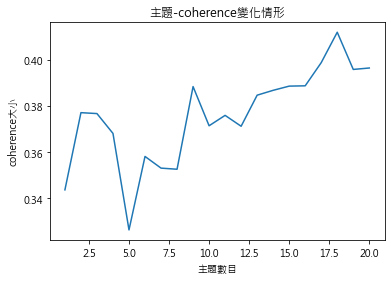

In [22]:
@jit(target_backend='cuda') 
def coherence_count(num_topics):
    x = range(1,num_topics+1)
    y = [coherence(i) for i in x]
    # z = [perplexity(i) for i in x]

    return x, y
    
x, y = coherence_count(20)

# num_topics = 20
# x = range(1,num_topics+1)
# y = [coherence(i) for i in x]

plt.plot(x,y)
plt.xlabel("主題數目")
plt.ylabel("coherence大小")
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
plt.title("主題-coherence變化情形")
plt.show()

In [25]:
num_topics = 9
lda = LdaModel(corpus, num_topics = num_topics, id2word = dictionary, passes = 30, random_state = 42)
topics_lst = lda.print_topics()
print(topics_lst)

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(data, f"./{num_topics}_topic_model.html")

[(0, '0.007*"台北" + 0.005*"覺得" + 0.004*"高虹安" + 0.004*"現在" + 0.004*"台灣" + 0.004*"市長" + 0.003*"支持" + 0.003*"桃園" + 0.003*"知道" + 0.003*"哪裡"'), (1, '0.005*"支持" + 0.005*"國民黨" + 0.005*"高虹安" + 0.005*"現在" + 0.004*"民進黨" + 0.004*"農田" + 0.004*"地方" + 0.004*"覺得" + 0.004*"水利會" + 0.003*"柯文哲"'), (2, '0.006*"新聞" + 0.005*"台灣" + 0.005*"議員" + 0.004*"現任" + 0.004*"民進黨" + 0.004*"助理" + 0.004*"日本" + 0.004*"高虹安" + 0.004*"林耕仁" + 0.004*"國民黨"'), (3, '0.006*"台灣" + 0.005*"新聞" + 0.004*"綠營" + 0.004*"請問" + 0.004*"桃園" + 0.003*"民進黨" + 0.003*"表示" + 0.003*"市長" + 0.003*"資金" + 0.003*"知道"'), (4, '0.016*"陳時中" + 0.011*"民進黨" + 0.009*"現在" + 0.008*"台灣" + 0.006*"中國" + 0.006*"蔡英文" + 0.006*"疫苗" + 0.005*"防疫" + 0.005*"林智堅" + 0.004*"新聞"'), (5, '0.010*"新聞" + 0.010*"文章" + 0.007*"黃珊珊" + 0.005*"疫苗" + 0.005*"轉錄" + 0.005*"陳時中" + 0.005*"內容" + 0.005*"網址" + 0.005*"政府" + 0.005*"選舉"'), (6, '0.008*"台灣" + 0.006*"新聞" + 0.006*"核電廠" + 0.005*"美國" + 0.005*"林智堅" + 0.005*"問題" + 0.005*"現在" + 0.004*"烏克蘭" + 0.004*"表示" + 0.004*"中國"'), (7, '0.033*"死亡" + 0.031*"累計

# sklearn LDA(TF-IDF)

In [24]:
seg_concat_lst = [" ".join(i) for i in seg_lst]
seg_concat_lst

['前院長 陳水扁 出身 貧窮 苦讀 完成 學業 經濟 科班 出身 公職 拼出 亮麗 經濟 成果 出身 貧窮 苦讀 完成 學業 經濟 科班 出身 公職 拼出 亮麗 經濟 成果 山東 台灣 台灣 帶領 台灣 破敗 走向 繁榮 台南 台北 台灣 帶領 台灣 繁榮 走向 破敗 傳記 兒子 當兵 國防部長 知道 報導 兒子 當兵 積架車 上下班 工商界 解決 經營 問題 工商界 解決 經濟 問題 瞭解 事蹟 心情 感動 飆淚 瞭解 事蹟 心情 激動 開罵 風範 地方 展現 玷污 先生',
 '變調 童話 國王 新衣 王子 爭奪戰 脫穎而出 實力 背負 改變 革新 廉潔 民眾 期待 加冕 典禮 慷慨 激昂 民眾 演說 擘畫 施政 藍圖 大多數 國人 相信 帶來 希望 帶來 快樂 帶來 清廉 帶來 進步 大學士 皇位 爭奪戰 關鍵 時點 說出 選擇 沈淪 提升 大多數 國人 相信 代表 力量 轉眼間 在位 帶給 許多 快樂 希望 子女 期間 結婚 生子 幸福 美滿 名下 財產 期間 逐年 高升 妻子 低調 私密 後宮 轉型成 政商 名流 絡繹不絕 軍機處 寵臣 把持 朝政 縱橫 商場 家奴 號令 百官 呼風喚雨 死去 靈位 成為 提督 清明 弔唁 所在 宮廷 後宮 駙馬府 地方 攀親帶故 人士 炙手可熱 人士 統稱為 當朝 權貴 當朝 權貴 發現 天底下 所有 好事 發生 投資 買賣 賺錢 保證 大賺 鐵酒 官營 機關 掌櫃 師爺 小小 千夫長 關照 自願 從軍 皇子 破格 拔擢成 邊關 大將 太醫院 任職 駙馬 速度 躍升 跨足 成為 商豪 宴會 貴賓 裡頭 政敵 刻意 放出 風言風語 混淆 視聽 事件 不斷 爆發 不斷 蔓延 不斷 發展 道德 標準 實際 擺盪 法律 要求 邊緣 掌權 利益 迴避 低調 避嫌 視若無睹 肆無忌憚 身為 中下 階層 努力 生活 認真 工作 民眾 感想 民眾 觀感 確定 含糊 概念 名嘴 爆料 隱含 惡毒 動機 不實 指控 親痛仇快 視為 惡意 栽贓 爆料 找出 一些 蛛絲馬跡 朝野 震動 全民 憤慨 最後 停損點 損害 控管 寵臣 一些 革掉 一些 烏紗帽 民眾 信任度 降低 駙馬爺 皇帝娘 家奴 事件 緊接 故事 廉價 歹戲拖棚 肥皂劇 扣人心懸 嘆為觀止 安徒生 國王 新衣 童話 喜愛 漂亮 衣服 國王 騙子 蒙蔽 自以為 穿上 華麗 新衣

In [25]:
TEST_DATA["seg_concat_lst"] = seg_concat_lst
TEST_DATA

,article_title,content,message_count_all,message_count_boo,message_count_count,message_count_neutral,message_count_push,seg_concat_lst
0,[狂幹] 孫運璿 vs 陳水扁,孫前院長和陳水扁的比較： 出身貧窮人家，苦讀完成學業，非經濟科班出身，任公職後，卻能為國拼出...,233,49,58,77,107,前院長 陳水扁 出身 貧窮 苦讀 完成 學業 經濟 科班 出身 公職 拼出 亮麗 經濟 成果...
1,[無言] 國王的新衣,變調的童話：國王的新衣 他能在眾王子的爭奪戰中脫穎而出，除了自身的實力 其實也背負著全國極欲...,85,7,32,39,39,變調 童話 國王 新衣 王子 爭奪戰 脫穎而出 實力 背負 改變 革新 廉潔 民眾 期待 加...
2,[吐嘈] =====沈老大在53台，婊DPP的4個影片片段=====,2006/05/17 民視新聞台 頭家來開講 婊DPP的4個clips 每一段都是切重要害的...,47,3,27,14,30,2006/05/17 民視 新聞台 頭家 開講 婊 切重 要害 檢討 清流 阿清流 綠色...
3,[大話] 笑話新聞 徐議員批馬片段,其實不只有徐議員啦 其他的人的講法 也大多都有入鏡 =================分格線...,21,1,11,8,12,議員 講法 入鏡 分格線 建議 第3 4 斟酌 第一 UP0x0 第二 http://w...
4,[轉錄][囧rz]安西教練：「三井，你負責投外線！」,作者: mushishi (蟲師) 看板: joke 標題: [囧rz]安西教練：三井，你負...,150,3,134,10,137,作者 蟲師 看板 標題 安西 教練 三井 負責 外線 時間 22 01:35:45 200...
5,[惡搞] 羞身 歧家 滯國 貧天下,這就是扁最好的寫照: 羞身 滿嘴粗言惡語罄竹難書.口口聲聲 嘔臭了嗎. 歧家 全家大大小小都...,43,3,24,13,27,寫照 羞身 粗言 惡語 罄竹難書 口口 聲聲 嘔臭 歧家 大大小小 貪瀆 奢侈 濫用 公權...
6,Re: 大陸人樂什麼樂阿,轉錄些中國人對駙馬事件的有趣評論 拚命抹黑.(指CCTV) 剛好讓人對比什麼是光明什麼是黑暗...,28,3,16,6,19,轉錄 中國人 駙馬 事件 有趣 評論 拚命 抹黑 對比 光明 黑暗 弄巧成拙 邱毅 橫屍 街...
7,[轉錄][囧rz] 改的不好請見諒!陋室銘之趙建銘版!,作者: germ0807 (大喊小牛加油) 看板: joke 標題: [囧rz] 改的不好請...,35,2,16,15,18,作者 germ0807 大喊 小牛 加油 看板 標題 見諒 陋室銘 趙建銘 時間 30 ...
8,[吐嘈] 民進黨的反撲...,拉法葉案各位 是拉法葉案啊 天啊，我感動的快要哭了，沒有想到民進黨還記得拉法葉案 想當初阿扁...,32,2,22,6,24,拉法葉案 拉法葉案 感動 想到 民進黨 記得 拉法葉案 當初 阿扁 上台 信誓蛋蛋 動搖 國...
9,[吐嘈] 阿扁向人民報告－收視率走勢圖,40 兩蔣權力大也沒人敢管 30 沒介入SOGO 不知道台開 20 10 我是族群對立的受...,10,1,6,2,7,40 兩蔣 權力 30 介入 知道 台開 20 10 族群 對立 受害 20:...


In [27]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(TEST_DATA["seg_concat_lst"])
feature_names = tf_idf_vectorizer.get_feature_names()
matrix = tf_idf.toarray()
feature_names_df = pd.DataFrame(matrix,columns=feature_names)

feature_names_df

,00,01,02,03,04,05,08,10,17,18,...,駙馬爺,騙子,高升,高於,高級,鴻儒,黃金羔,黑暗,黨派,鼓掌
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047493,0.047493,0.047493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.108332,0.216665,0.127436,0.108332,0.127436,0.000000,0.127436,0.108332,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.122103,0.207598,0.103799,0.000000,0.311397,0.000000,0.000000,0.000000,0.103799,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.142215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.048918,0.000000,0.048918,0.048918,0.048918,0.048918
7,0.110723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.130248,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.410370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.241368,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
def top_words_data_frame(model: LatentDirichletAllocation,
                         tf_idf_vectorizer: TfidfVectorizer,
                         n_top_words: int) -> pd.DataFrame:
    '''
    求出每个主题的前 n_top_words 个词

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    tf_idf_vectorizer : sklearn 的 TfidfVectorizer
    n_top_words :前 n_top_words 个主题词

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    rows = []
    feature_names = tf_idf_vectorizer.get_feature_names()
    for topic in model.components_:
        top_words = [feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        rows.append(top_words)
    columns = [f'topic {i+1}' for i in range(n_top_words)]
    df = pd.DataFrame(rows, columns=columns)

    return df

def predict_to_data_frame(model: LatentDirichletAllocation, X: np.ndarray) -> pd.DataFrame:
    '''
    求出文档主题概率分布情况

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    X : 词向量矩阵

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    matrix = model.transform(X)
    columns = [f'P(topic {i+1})' for i in range(len(model.components_))]
    df = pd.DataFrame(matrix, columns=columns)
    return df


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# 指定 lda 主题数
n_topics = 6
n_top_words = 15

lda = LatentDirichletAllocation(
    n_components=n_topics, max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=0)
print(lda)

lda.fit(tf_idf)

# 计算 n_top_words 个主题词
top_words_df = top_words_data_frame(lda, tf_idf_vectorizer, n_top_words)

# 转 tf_idf 为数组，以便后面使用它来对文本主题概率分布进行计算
X = tf_idf.toarray()

# 计算完毕主题概率分布情况
predict_df = predict_to_data_frame(lda, X)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=6, random_state=0)


In [37]:
predict_df

,P(topic 1),P(topic 2),P(topic 3),P(topic 4),P(topic 5),P(topic 6)
0,0.023955,0.023947,0.023949,0.023951,0.023950,0.880247
1,0.011066,0.011064,0.011067,0.011067,0.944670,0.011067
2,0.026600,0.867066,0.026582,0.026582,0.026578,0.026592
3,0.021461,0.021546,0.021467,0.021466,0.021462,0.892597
4,0.029037,0.854765,0.029040,0.029043,0.029079,0.029035
5,0.889539,0.022083,0.022089,0.022089,0.022083,0.022117
6,0.015308,0.015308,0.015306,0.015305,0.015305,0.923468
7,0.020318,0.020333,0.020293,0.020294,0.898443,0.020318
8,0.028127,0.028120,0.028131,0.028127,0.028124,0.859372
9,0.816909,0.036629,0.036611,0.036611,0.036624,0.036616


NER

In [132]:
ner_lst = []
for i in range(0,10):
    ner_results = ner_driver([content[i]])
    ner_filter=['PERSON','ORG','GPE','MONEY','NORP','LOC','FAC','EVENT','PRODUCT','LAW']
    ner = [(j.word, j.ner) for j in ner_results[0] if j.ner in ner_filter]
    ner_lst.append(ner)



Tokenization: 100%|██████████| 1/1 [00:00<00:00, 333.25it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]

Inference: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

Tokenization: 100%|██████████| 1/1 [00:00<?, ?it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 503.28it/s]

Inference: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

Tokenization: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

Inference: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

Tokenization: 100%|██████████| 1/1 [00:00<00

In [133]:
ner_results

[[NerToken(word='蔣', ner='PERSON', idx=(5, 6)),
  NerToken(word='台開', ner='ORG', idx=(29, 31)),
  NerToken(word='20:00 21:00 ', ner='TIME', idx=(49, 61))]]

In [24]:
ner_list = pd.DataFrame()
ner_list["ner_lst"] = ner_lst
ner_list.to_csv("/content/drive/MyDrive/NLP/ner_lst.csv", encoding='utf-8')

In [ ]:
def NER_select(ner_lst, ner_type):
  NER_count = Counter()
  for i in ner_lst:
    for j in i:
      n = []
      if j[1] == ner_type and len(j[0]) > 1:
        n.append(j[0])

      ner_count = Counter(n)
      NER_count+=ner_count

  return NER_count

NER_count = NER_select(ner_lst, "PERSON")


(-0.5, 399.5, 199.5, -0.5)

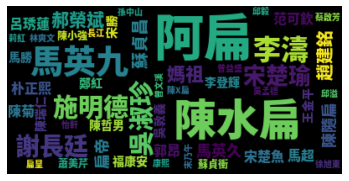

In [ ]:
font_path = '/content/NotoSansTC-Black.otf'
wordcloud = WordCloud(max_words = 50, font_path=font_path).generate_from_frequencies(NER_count)
# cloud.to_file('output.png')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")